# **Final Assigment: Yahoo Answers Topic**

# *** Part 3***

---

We created a separate notebook to implement for part 3. We exported the best model from part 2 to hugging face, so now we can simply import that model to run on the varying proportions of the dataset.

We implement the preprocessing and data cleaning code to implement the main dataframe, and then we load the exported model that we had from part 2 from hugging face. From there, we can implement the code that we need for part 3.

We ran this part in kaggle thanks to its 30 free hours of GPU usage.

we re-load needed libraries

In [1]:

# run if colab/kaggle
!pip install -U transformers

!pip install -U datasets fsspec # run this if you run with colab.

!pip install -U datasets evaluate

!pip install nltk
import nltk
nltk.download('stopwords')
!pip install wordcloud

!pip install lime

!pip install -U scikit-learn
!pip install matplotlib

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from datasets import Dataset
import evaluate
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random

2025-06-14 09:47:16.441067: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749894436.463762     166 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749894436.470543     166 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# DO NOT RUN IN KAGGLE
#!pip uninstall scikit-learn -y
#!pip install scikit-learn==1.6.1



We put all of the df preprocessing and loading of the yahoo answers topic into one chunk so that we can run and load it in one go.

In [5]:
from datasets import load_dataset
import pandas as pd

# Load the dataset
train_dataset = load_dataset("community-datasets/yahoo_answers_topics", split="train")
test_dataset = load_dataset("community-datasets/yahoo_answers_topics", split="test")

# Convert to pandas DataFrame for easier handling
df = pd.concat([train_dataset.to_pandas(), test_dataset.to_pandas()]).reset_index(drop=True)
label_map = {'Society & Culture': 0, 'Science & Mathematics': 1, 'Health': 2, 'Education & Reference': 3,
             'Computers & Internet': 4, 'Sports': 5, 'Business & Finance': 6, 'Entertainment & Music': 7,
             'Family & Relationships': 8, 'Politics & Government': 9}


# Show basic info
print(f"Dataset size: {len(df)} documents")


# I imported a library that detects the language of the text.
!pip install langdetect
from langdetect import detect
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

from collections import defaultdict
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
from lime.lime_text import LimeTextExplainer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
#from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import pandas as pd


from sklearn.manifold import TSNE
from collections import Counter
import re

from datasets import load_dataset, DatasetDict
from transformers import (AutoTokenizer,
                          AutoModelForSequenceClassification,
                          TrainingArguments, Trainer,
                          EarlyStoppingCallback)
import evaluate, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
import torch, random, os
from datasets import Dataset, DatasetDict

import string
from transformers import pipeline

empty_questions = df['question_content'].apply(lambda x: x.strip() == "")
empty_answers = df['best_answer'].apply(lambda x: x.strip() == "")

print("Empty questions:", empty_questions.sum())
print("Empty answers:", empty_answers.sum())

df = df[~empty_questions & ~empty_answers]

Dataset size: 1460000 documents
Empty questions: 658761
Empty answers: 25606


we verify that we have the dataset intact.

In [7]:
df.head()

,id,topic,question_title,question_content,best_answer
0,0,4,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,1,5,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,2,2,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...
3,3,6,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...
4,4,6,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...


now we load the model from part 2

In [8]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# load model directly
tokenizer = AutoTokenizer.from_pretrained("tirdodbehbehani/yahoo-bert-32shot_stratified_augm_2")
model = AutoModelForSequenceClassification.from_pretrained("tirdodbehbehani/yahoo-bert-32shot_stratified_augm_2")

tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

# Part 3: State of the Art Comparison (2 points)

In this section, we shall benchmark our model against the SOA with the full dataset now available.

## a) Full Dataset Training (0.25 points):
Incrementally train your model with varying percentages of the full dataset (1%, 10%, 25%, 50%, 75%, and 100%). Record the results.

In [9]:
# Set model parameters
model_ckpt = "tirdodbehbehani/yahoo-bert-32shot_stratified_augm_2"
num_labels = 10
max_length = 128
batch_size = 100
seed = 42

In [10]:
#preprocess
df_model = df[['question_content', 'topic']].copy()

df_model = df[['question_content', 'topic']].rename(columns={'topic': 'label'})

df_model.head()

# Convert full dataframe to HF Dataset  (for standard split)
full_dataset = Dataset.from_pandas(df_model).shuffle(seed=seed)

In [11]:
full_dataset

Dataset({
    features: ['question_content', 'label', '__index_level_0__'],
    num_rows: 785942
})

In [12]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["question_content"], padding="max_length", truncation=True, max_length=max_length)

for small percentages we say less than or equal to 25%, we stratify the dataset. We do this to preserve the rough target labeling structure in small sample sizes

We proceed with normal tokenization when the percentage is greater than 25%. With the small dataset sample, we want to still make sure that our trainning and test sets are proportionally representative of the training data (i.e. making sure that we don't have major class imbalances. With the larger proportions of the dataset (i.e. greater than 50%), the model will likely have seen enough of the data that it will be less sensitive to potential class imbalances.

Below, we our model training function will dynamically select the stratified tokenized dataset if the dataset proportion is less than 25%, and select the standard tokenized dataset if not.

In [13]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

def stratified_tokenized_split(df_model, pct, seed=42):
    df_sample, _ = train_test_split(df_model, train_size=pct, stratify=df_model["label"], random_state=seed)
    train_df, test_df = train_test_split(df_sample, test_size=0.2, stratify=df_sample["label"], random_state=seed)
    train_ds = Dataset.from_pandas(train_df.reset_index(drop=True)).map(tokenize, batched=True)
    test_ds = Dataset.from_pandas(test_df.reset_index(drop=True)).map(tokenize, batched=True)
    train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    test_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    return train_ds, test_ds

def standard_tokenized_split(dataset, pct, seed=42):
    size = int(len(dataset) * pct)
    subset = dataset.select(range(size))
    split = subset.train_test_split(test_size=0.2, seed=seed)
    train_ds = split["train"].map(tokenize, batched=True)
    test_ds = split["test"].map(tokenize, batched=True)
    train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    test_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    return train_ds, test_ds

Here is where we implement our model training function and pipeline. It is largely the implementation as what we saw in part 2.

As we mentioned above, training models on this size of data is very computationally costly. Thus, we want to make sure

In [14]:
import evaluate
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np

# here we implement the code/function to get the accuracy, precision, and recall performance metrics
metric_accuracy  = evaluate.load("accuracy")
metric_precision = evaluate.load("precision")
metric_recall    = evaluate.load("recall")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc  = metric_accuracy.compute(predictions=preds, references=labels)
    prec = metric_precision.compute(predictions=preds, references=labels, average="macro")
    rec  = metric_recall.compute(predictions=preds, references=labels, average="macro")

    # merge into a single dict that Trainer can log
    return {
        "accuracy":  acc["accuracy"],
        "precision": prec["precision"],
        "recall":    rec["recall"],
    }

# here is the function to train the model
def train_model(train_ds, test_ds, pct_label):
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)

    args = TrainingArguments(
        output_dir=f"/kaggle/working/yahoo_models/results_{pct_label}",

        eval_strategy       = "epoch",
        save_strategy       = "epoch",
        logging_strategy    = "epoch", #FIXED TO SEE LOGGING
        #logging_steps       = 50,
        learning_rate       = 2e-5,
        per_device_train_batch_size = batch_size,
        per_device_eval_batch_size  = batch_size,
        num_train_epochs    = 20,
        weight_decay        = 0.01,
        load_best_model_at_end = True,
        metric_for_best_model = "eval_loss",
        save_total_limit    = 2,
        seed                = seed,
        report_to           = "none",  # Disable wandb
        fp16                = True, # Enable mixed precision training
        gradient_accumulation_steps = 2
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        compute_metrics=compute_metrics,
        callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()
    return trainer.evaluate()

# as a precautionary measure, we implement a function to export some descriptive metrics about the model to a csv file
def log_metrics_to_file(pct, metrics, path="/kaggle/working/bert_part3_log.txt"):
    with open(path, "a") as f:
        f.write(f"===== {pct}% DATA =====\n")
        for k, v in metrics.items():
            f.write(f"{k}: {v:.4f}\n")
        f.write("\n")

To avoid bulk-running the varying model proportions in one for loop, we write a function made for model training, with an input for the desired model proportion. It also has inputs for the stratified and standard tokenized datasets.

In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

# Convert full dataframe to HF Dataset once (for standard split)
full_dataset = Dataset.from_pandas(df_model)

def run_training_for_percentage(
    pct,
    df_model,
    full_dataset,
    seed=42,
    results_path="/kaggle/working/bert_part3_results.csv"
):
    """
    Train model on a specific percentage of the data and log results to CSV.
    """
    print(f"\nTraining on {int(pct * 100)}% of data...")

    # Choose dataset split strategy
    if pct <= 0.25:
        train_ds, test_ds = stratified_tokenized_split(df_model, pct, seed)
    else:
        train_ds, test_ds = standard_tokenized_split(full_dataset, pct, seed)

    # Train and evaluate model
    metrics = train_model(train_ds, test_ds, pct_label=int(pct * 100))
    log_metrics_to_file(int(pct * 100), metrics)

    # Save to CSV
    results_df = pd.DataFrame([metrics])
    results_df.insert(0, "Percentage", int(pct * 100))

    # Append if file exists, else create
    from pathlib import Path
    csv_file = Path(results_path)

    if csv_file.exists():
        existing = pd.read_csv(results_path)
        combined = pd.concat([existing, results_df], ignore_index=True).drop_duplicates(subset=["Percentage"])
    else:
        combined = results_df

    combined.to_csv(results_path, index=False)
    print(f"Results saved/appended to: {results_path}")

    return metrics

We run the model on 1% of the (stratified) training data 

In [16]:
run_training_for_percentage(0.01, df_model, full_dataset)


Training on 1% of data...


Map:   0%|          | 0/6287 [00:00<?, ? examples/s]

Map:   0%|          | 0/1572 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,2.122300,1.906787,0.466921,0.496921,0.454578
2,1.648400,1.452824,0.596056,0.607812,0.587800
3,1.288100,1.259324,0.627863,0.628701,0.623819
4,1.079100,1.194286,0.633588,0.632969,0.629950
5,0.929800,1.182610,0.643130,0.639346,0.640258
6,0.815600,1.180915,0.644402,0.643420,0.641337
7,0.711500,1.205860,0.645038,0.639785,0.642622
8,0.624000,1.215591,0.646310,0.642162,0.645707
9,0.550500,1.239258,0.636132,0.634236,0.633725


Results saved/appended to: /kaggle/working/bert_part3_results.csv


{'eval_loss': 1.1809149980545044,
 'eval_accuracy': 0.6444020356234097,
 'eval_precision': 0.6434204200877522,
 'eval_recall': 0.6413368450872539,
 'eval_runtime': 5.3732,
 'eval_samples_per_second': 292.561,
 'eval_steps_per_second': 2.978,
 'epoch': 9.0}

The 1% proportion requires 9 epochs before early stopping is implemented. From the 4th epoch onward, the validation loss concentrated around 1.18 through 1.23. Accuracy, precision, and recall all hovered around 0.62 - 0.64.

Considering that we have 10 classes, predicting more than roughly 6 out of every 10 labels is a good starting point.

In [17]:
run_training_for_percentage(0.10, df_model, full_dataset)


Training on 10% of data...


Map:   0%|          | 0/62875 [00:00<?, ? examples/s]

Map:   0%|          | 0/15719 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,1.301500,1.059516,0.663655,0.661454,0.660046
2,0.969200,1.023519,0.671862,0.667920,0.668082
3,0.845800,1.034887,0.673325,0.674412,0.668097
4,0.733400,1.075482,0.667027,0.664800,0.662995
5,0.632200,1.124956,0.664864,0.662009,0.661025


Results saved/appended to: /kaggle/working/bert_part3_results.csv


{'eval_loss': 1.0235192775726318,
 'eval_accuracy': 0.6718620777403143,
 'eval_precision': 0.6679202340154575,
 'eval_recall': 0.6680815367447878,
 'eval_runtime': 53.67,
 'eval_samples_per_second': 292.883,
 'eval_steps_per_second': 2.944,
 'epoch': 5.0}

Conversely, the model on 10% of the data requires only 5 epochs before early stopping is implemented. The validation loss, accuracy, precision, and recall are all improved relative to the model on 1% of the data. Furthermore, we observe that the variance of the metrics is lower across epochs relative to the model on 1% of the data.

For reference, the lowest validation loss of 1.02 with the model on 10% of the data is 0.16 better than the model on 1% of the data, which is almost a 16% improvement.

In [18]:
run_training_for_percentage(0.25, df_model, full_dataset)


Training on 25% of data...


Map:   0%|          | 0/157188 [00:00<?, ? examples/s]

Map:   0%|          | 0/39297 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,1.145200,0.989411,0.675700,0.680283,0.671683
2,0.922100,0.980213,0.682927,0.679443,0.678874
3,0.814500,0.984926,0.682393,0.683718,0.677788
4,0.715500,1.046384,0.677380,0.674796,0.673856
5,0.621700,1.098959,0.674403,0.673167,0.670892


Results saved/appended to: /kaggle/working/bert_part3_results.csv


{'eval_loss': 0.9802131652832031,
 'eval_accuracy': 0.6829274499325648,
 'eval_precision': 0.6794434364407926,
 'eval_recall': 0.6788736605533877,
 'eval_runtime': 133.7428,
 'eval_samples_per_second': 293.825,
 'eval_steps_per_second': 2.938,
 'epoch': 5.0}

Above, we ran the models for the intervals of 1%, 10%, and 25% of the training data. We have a very large dataset (over 1.4M documents), so running the model for larger percentages of the dataset was very computationally costly. 

Ultimately, due to GPU limit issues and the dataset size, we were only able to run the models on at most 25% of the dataset. However, given the large dataset size, we do not believe that this will have a huge impact on the results. We can see that our models are implementing early stopping and running with less epochs over time, indicating that our models are marginally learning less information as we add more data. Furthermore, we observe our accuracy, precision, and recall metrics all converge.

We will see an empirical representation of this in the below learning rate figure.

  ## b) Learning Curve (0.25 points): Plot a learning curve based on the training data percentages.

In [28]:
import json
import os
import matplotlib.pyplot as plt

def get_latest_checkpoint_state_path(base_dir):
    checkpoints = [d for d in os.listdir(base_dir) if d.startswith("checkpoint-")]
    if not checkpoints:
        raise FileNotFoundError(f"No checkpoint folders found in {base_dir}")
    latest = sorted(checkpoints, key=lambda x: int(x.split("-")[1]))[-1]
    return os.path.join(base_dir, latest, "trainer_state.json")

def load_log_history(pct):
    base_dir = f"/kaggle/working/yahoo_models/results_{pct}"  # adjust this if your folder names are different
    path = get_latest_checkpoint_state_path(base_dir)
    with open(path, "r") as f:
        state = json.load(f)
    history = state["log_history"]
    val_losses = [entry["eval_loss"] for entry in history if "eval_loss" in entry]
    return val_losses

def plot_learning_curves(pcts=[1, 10, 25]):
    plt.figure(figsize=(10, 6))

    for pct in pcts:
        val_losses = load_log_history(pct)
        epochs = list(range(1, len(val_losses) + 1))
        plt.plot(epochs, val_losses, marker="o", label=f"{pct}% of data")

    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss (Log scaled)")
    plt.yscale("log") 
    plt.title("Validation Loss Learning Curves (Log-Scaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

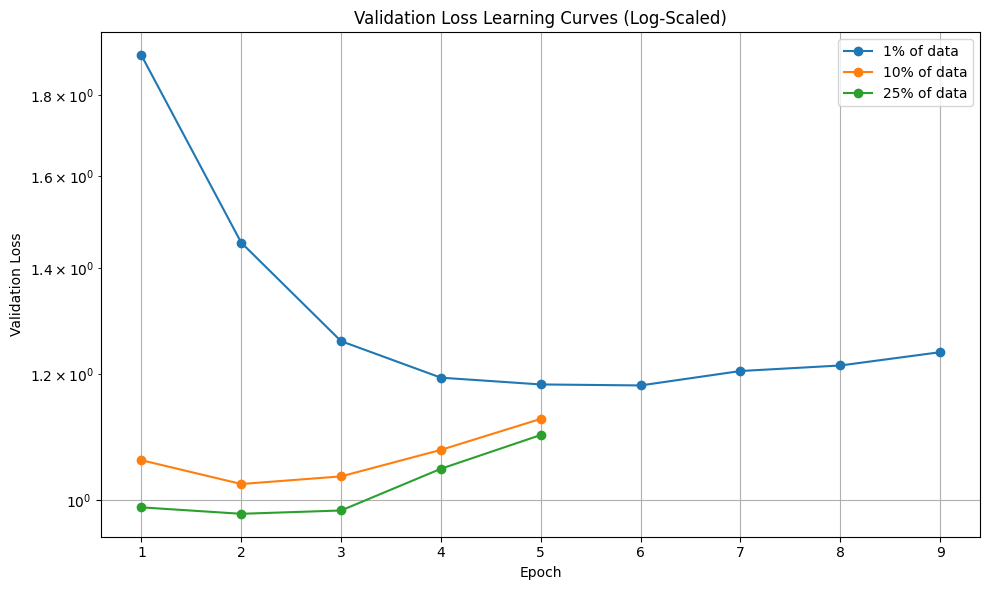

In [27]:
plot_learning_curves([1, 10, 25])

Interesting enough, we observe the the 10% and 25% models implemented early stopping at the 5th epoch. While the training losses were declining, we can see that this only led to an increase in the validation loss. This is likely due to overfitting on the training data.

However, we can still see that the loss for the 25% model is the lowest, followed by the 10% model and the 1% model. The loss curve for the 10% model is much closer for the 25% model than it is to the 1% model, which is as we expected. 

We further look into the results through getting the true loss data values and investigating the accuracy, precision, and recall.

Final Evaluation Metrics by Training Percentage:



,Percentage,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,1,1.1809,0.6444,0.6434,0.6413,5.3732,292.561,2.978,9.0
1,10,1.0235,0.6719,0.6679,0.6681,53.6700,292.883,2.944,5.0
2,25,0.9802,0.6829,0.6794,0.6789,133.7428,293.825,2.938,5.0


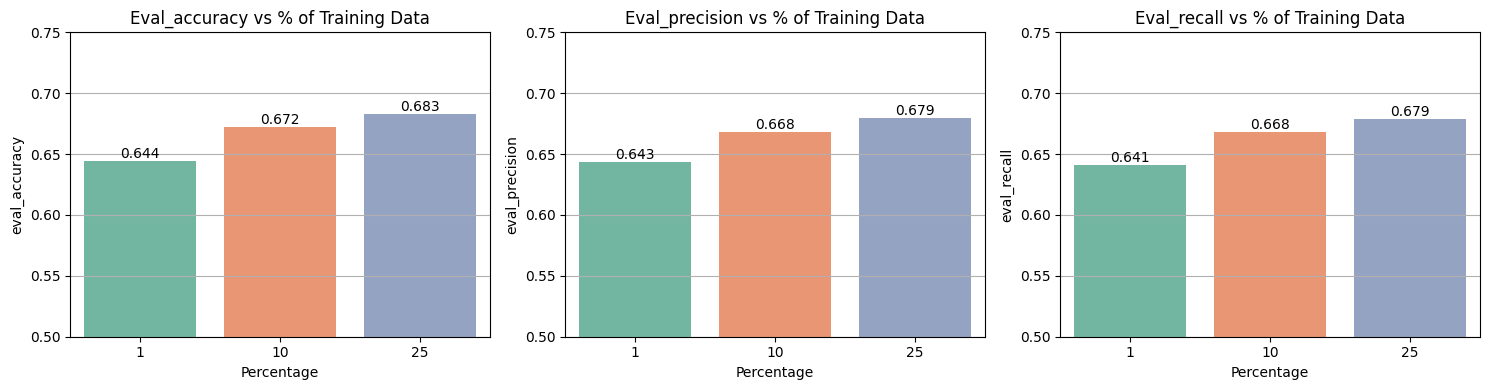

In [40]:
import pandas as pd

# Path to the saved CSV from earlier training runs
results_path = "/kaggle/working/bert_part3_results.csv"

# Load and display results
results_df = pd.read_csv(results_path)
results_df = results_df.sort_values("Percentage")

# Round for readability
results_df_rounded = results_df.round(4)

# Show the table
print("Final Evaluation Metrics by Training Percentage:\n")
display(results_df_rounded)

# plot the accuracy, precision, and recall across training percentages
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for i, metric in enumerate(metrics):
    sns.barplot(ax=axs[i], x="Percentage", y=metric, data=results_df, palette="Set2")
    axs[i].set_title(f"{metric.capitalize()} vs % of Training Data")
    axs[i].set_ylim(0.5, 0.75)  # tighter range for visibility
    axs[i].grid(True, axis="y")

    # Annotate bar values
    for p in axs[i].patches:
        height = p.get_height()
        axs[i].annotate(f"{height:.3f}",
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

Now we observe the graphical representation of the learning rates. As mentioned above, we observe diminishing learning returns as we feed more and more data to the model. The 1% of the data is worse, while the 10% and 25% models observe quite similar performance.

- The loss reduction from 1% to 10% is 0.16
- The loss reduction from 10% to 25% is 0.04
- The loss reduction from 1% to 25% is 0.20

- The accuracy improvement from 1% to 10% is 0.03
- The accuracy improvement from 10% to 25% is 0.01
- The accuracy improvement from 1% to 25% is 0.04

The first 9% of data resulted in a loss reduction of 0.16, and the next 15% of data only resulted in a loss reduction of 0.04. The core patterns in the data are learned early on, and less additional information is gained from the subsequent samples.

We run the model on some unseen proportions to view a confusion matrix. This would have been done right on the same test data we had from the models if possible, but this was not has feasible as we had hoped because of how we do not globally save the stratified df that was used for model training. This was an error in foresight, and we did not have sufficient time to improve the code and run the model again due to computational cost concerns.

In [51]:
def get_stratified_test_set(df_model, pct, seed=42):
    df_sample, _ = train_test_split(df_model, train_size=pct, stratify=df_model["label"], random_state=seed)
    _, test_df = train_test_split(df_sample, test_size=0.2, stratify=df_sample["label"], random_state=seed)
    test_ds = Dataset.from_pandas(test_df.reset_index(drop=True)).map(tokenize, batched=True)
    test_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    return test_ds

test_1 = get_stratified_test_set(df_model, 0.01)
test_10 = get_stratified_test_set(df_model, 0.10)
test_25 = get_stratified_test_set(df_model, 0.25)

def plot_confusion_matrix_batched(model_dir, test_dataset, title, tokenizer_ckpt="tirdodbehbehani/yahoo-bert-32shot_stratified_augm_2", batch_size=100):
    from transformers import AutoModelForSequenceClassification, AutoTokenizer
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    from torch.utils.data import DataLoader
    import torch
    import matplotlib.pyplot as plt

    # Load model and tokenizer
    model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_ckpt)
    model.eval()

    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Create DataLoader for batching
    dataloader = DataLoader(test_dataset, batch_size=batch_size)

    all_preds, all_labels = [], []

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].cpu().numpy()

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, axis=-1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(title)
    plt.show()

Map:   0%|          | 0/1572 [00:00<?, ? examples/s]

Map:   0%|          | 0/15719 [00:00<?, ? examples/s]

Map:   0%|          | 0/39297 [00:00<?, ? examples/s]

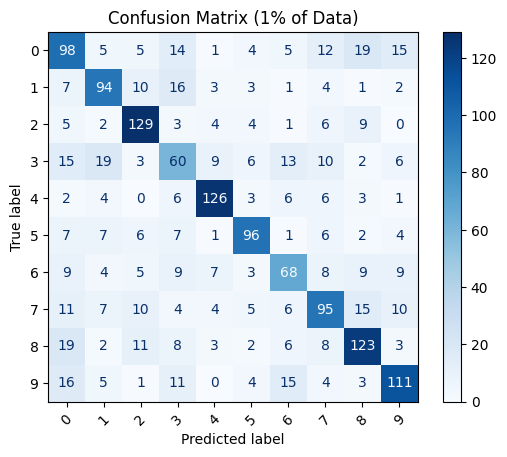

In [53]:
plot_confusion_matrix_batched(
    model_dir="/kaggle/working/yahoo_models/results_1/checkpoint-288",
    test_dataset=test_ds_1,
    title="Confusion Matrix (1% of Data)"
)


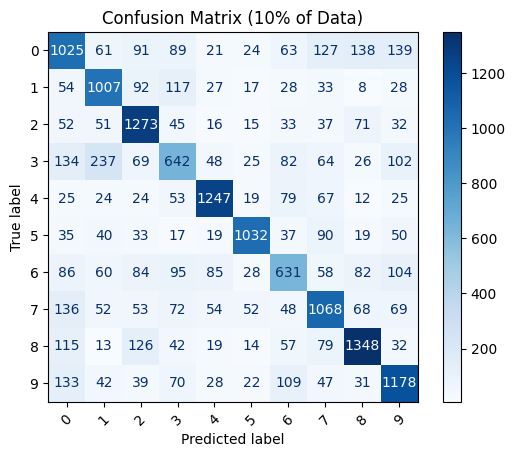

In [54]:
plot_confusion_matrix_batched(
    model_dir="/kaggle/working/yahoo_models/results_10/checkpoint-1575",
    test_dataset=test_ds_10,
    title="Confusion Matrix (10% of Data)"
)


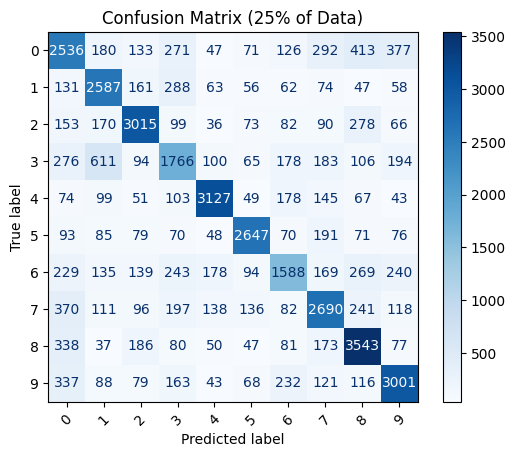

In [55]:
plot_confusion_matrix_batched(
    model_dir="/kaggle/working/yahoo_models/results_25/checkpoint-3930",
    test_dataset=test_ds_25,
    title="Confusion Matrix (25% of Data)"
)

We can see from the confusion matrices perform pretty well. The most common predictions for all 10 classes are the true labels, across the model on the 1%, 10%, and 25% proportions of the data.

Recall that our data is stratified, so we were expecting equal distribution across classes

## c) Technique Comparison (0.5 points): Incorporate the techniques tested in Part 2 into your training schema for comparison.

Now, we will incorporate the tested techniques from part 2 with the added data. We will try 1 masked token prediction and generating synthetic data. We suspect that the synthetic data generation will not lead to the same level of model improvement performance that we observed in part 2, given that we now have much more data available to us

Due to computational cost concerns, we only run these models on 10% of the dataset. 

### Technique 1: 1 Masked Token Prediction

In [94]:
# Get 10% stratified sample from df
df_sample, _ = train_test_split(
    df,
    train_size=0.10,
    stratify=df["topic"],
    random_state=42
)

## From that 10%, take 80% train / 20% test
#stratified_train_df, stratified_test_df = train_test_split(
#    df_sample,  
#    test_size=0.2,
#    stratify=df_sample["topic"],
#    random_state=42
#)

# Add this before loop
df_sample = df_sample[
    df_sample["question_content"].apply(lambda x: len(tokenizer.tokenize(x)) <= 512)
].reset_index(drop=True)

In [ ]:
from transformers import pipeline, AutoTokenizer
import pandas as pd
import random

# Load BERT fill-mask pipeline and tokenizer
fill_mask = pipeline("fill-mask", model="bert-base-uncased")

# Augmentation function with 512-token check
def augment_sentence(sentence, top_k=3):
    # Skip overly long sentences
    if len(tokenizer.tokenize(sentence)) > 512:
        return []

    words = sentence.split()
    if len(words) < 3:
        return []

    candidate_indices = [i for i, w in enumerate(words) if w.isalpha()]
    if not candidate_indices:
        return []

    idx = random.choice(candidate_indices)
    words[idx] = '[MASK]'
    masked_sentence = ' '.join(words)

    try:
        predictions = fill_mask(masked_sentence, top_k=top_k)
    except Exception:
        return []

    augmented = []
    for p in predictions:
        filled_sentence = masked_sentence.replace('[MASK]', p['token_str'])
        if filled_sentence.strip() != sentence.strip():
            augmented.append(filled_sentence)
    return augmented

# Apply augmentation to training data
augmented_rows = []
for text, label in zip(df_sample["question_content"], df_sample["topic"]):
    new_sentences = augment_sentence(text, top_k=1)
    for aug in new_sentences:
        augmented_rows.append({
            "question_content": aug,
            "topic": label
        })

# Create dataframe of augmented data
df_aug = pd.DataFrame(augmented_rows)
print(f"\n Augmentation complete: {len(df_aug)} new examples generated.")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [88]:
df_combined = pd.concat([df_sample, df_aug], ignore_index=True)
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

In [89]:
# Map "topic" to label IDs
label_to_id = {label: idx for idx, label in enumerate(sorted(df_combined["topic"].unique()))}
df_combined["label"] = df_combined["topic"].map(label_to_id)

# Convert to HF Dataset
ds_combined = Dataset.from_pandas(df_combined[["question_content", "label"]])

In [90]:
ds_combined

Dataset({
    features: ['question_content', 'label'],
    num_rows: 118157
})

In [91]:
# Tokenize
def tokenize(batch):
    return tokenizer(batch["question_content"], padding="max_length", truncation=True, max_length=128)

ds_test = ds_combined.map(tokenize, batched=True)
ds_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])

ValueError: invalid literal for int() with base 10: 'question_content'

In [82]:
ds_test

Dataset({
    features: ['question_content', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 15719
})

In [80]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

all_preds, all_labels = [], []

for batch in ds_test:
    inputs = {
        "input_ids": batch["input_ids"].unsqueeze(0).to(device),
        "attention_mask": batch["attention_mask"].unsqueeze(0).to(device)
    }
    with torch.no_grad():
        output = model(**inputs)
        pred = torch.argmax(output.logits, dim=1).item()
        all_preds.append(pred)
        all_labels.append(batch["label"])

In [81]:
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("Precision (macro):", precision_score(all_labels, all_preds, average="macro"))
print("Recall (macro):", recall_score(all_labels, all_preds, average="macro"))
print("\nClassification Report:\n", classification_report(all_labels, all_preds))

Accuracy: 0.12672561867803295
Precision (macro): 0.1032866922622812
Recall (macro): 0.12309217384511813

Classification Report:
               precision    recall  f1-score   support

           0       0.12      0.24      0.16      1778
           1       0.02      0.00      0.00      1411
           2       0.00      0.00      0.00      1625
           3       0.12      0.28      0.16      1429
           4       0.21      0.13      0.16      1575
           5       0.08      0.16      0.11      1372
           6       0.10      0.05      0.06      1313
           7       0.10      0.02      0.03      1672
           8       0.17      0.29      0.21      1845
           9       0.11      0.07      0.08      1699

    accuracy                           0.13     15719
   macro avg       0.10      0.12      0.10     15719
weighted avg       0.11      0.13      0.10     15719



### Technique 2: 

### Technique 3: Data Generation with LLM

5% synthetic and 5% real

## d) Methodology Analysis (1 point): Analyze and compare all methods employed. Discuss the effectiveness and limitations observed.

Thus far, our model accuracy of __ has underperformed relative to the state of the art models that we discussed in part 1. 

As a refresher:


| Rank | Model             | Accuracy (%) | Paper Title                                                                 | Year |
|------|-------------------|--------------|------------------------------------------------------------------------------|------|
| 1    | BERT-ITPT-FiT     | 77.62        | How to Fine-Tune BERT for Text Classification?                              | 2019 |
| 2    | DRNN              | 76.26        | Disconnected Recurrent Neural Networks for Text Categorization              | 2018 |
| 3    | DELTA (HAN)       | 75.10        | DELTA: A DEep learning based Language Technology plAtform                   | 2019 |
| 4    | EXAM              | 74.80        | Explicit Interaction Model towards Text Classification                      | 2018 |
| 5    | DNC+CUW           | 74.30        | Learning to Remember More with Less Memorization                            | 2019 |
| 6    | ULMFiT (Small data)| 74.30       | Sampling Bias in Deep Active Classification: An Empirical Study             | 2019 |
| 7    | CCCapsNet         | 73.85        | Compositional Coding Capsule Network with K-Means Routing for Text Classification | 2018 |
| 8    | SWEM-concat       | 73.53        | Baseline Needs More Love: On Simple Word-Embedding-Based Models and Associated Pooling Mechanisms | 2018 |
| 9    | FastText          | 72.30        | Bag of Tricks for Efficient Text Classification                             | 2016 |
| 10   | Seq2CNN (50)      | 55.39        | Abstractive Text Classification Using Sequence-to-convolution Neural Networks | 2018 |

Our more simple BERT model has struggled relative to the state of the art. One obvious limitation that we have is computational power, as we were not able to train a model on more than 25% of the dataset.